# 3.7. Decadência de peso

Agora que caracterizamos o problema do overfitting, podemos apresentar nossa primeira técnica de __regularização__.

Lembre-se de que sempre podemos mitigar o overfitting coletando mais dados de treinamento. No entanto, isso pode ser caro, demorado ou totalmente fora do nosso controle, tornando-o impossível no curto prazo.

As extensões naturais de polinômios para dados multivariados são chamadas de monômios , que são simplesmente produtos de potências de variáveis. O grau de um monômio é a soma das potências. 

Mesmo pequenas mudanças de grau, digamos de 2 para 3, aumentam drasticamente a complexidade do nosso modelo. Portanto, muitas vezes precisamos de uma ferramenta mais refinada para ajustar a complexidade da função.



In [1]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

# 3.7.1. Normas e redução de peso

Em vez de manipular diretamente o número de parâmetros, a redução de peso opera restringindo os valores que os parâmetros podem assumir. Mais comumente chamado l2 regularização fora dos círculos de aprendizado profundo quando otimizada pela descida gradiente estocástica de minibatch, a redução de peso pode ser a técnica mais amplamente usada para regularizar modelos paramétricos de aprendizado de máquina.


l2 norma:
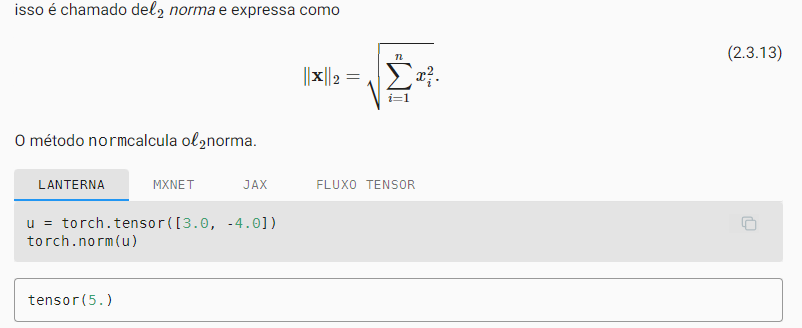

l1 norma e lp norma:
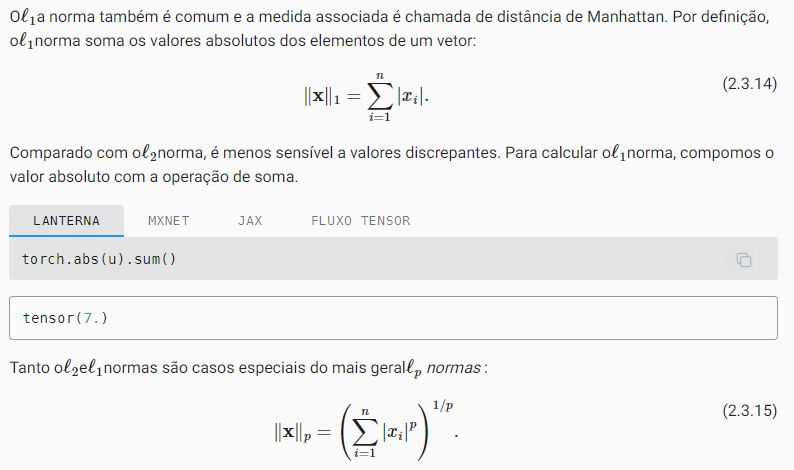

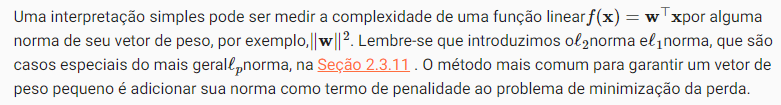



Perda utilizada na Regressão Linear: \
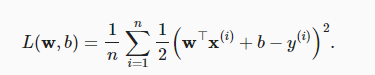

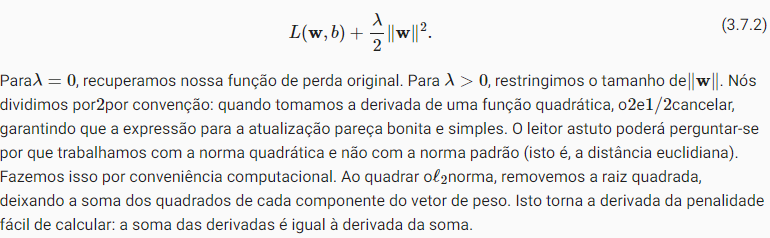

Isso impõe uma penalidade descomunal a grandes componentes do vetor de peso.

 Isso direciona nosso algoritmo de aprendizagem para modelos que distribuem o peso uniformemente por um número maior de recursos. 




$$
\textbf{w}\underset{}{\leftarrow}(1-\eta\lambda)\textbf{w}-\frac{\eta}{\left|\textbf{B}\right|}\sum_{i\in B}x^{(i)}(\textbf{w}^{\top}\textbf{x}^{(i)}+b-y^{(i)})\\ \\ \\
$$




$$
onde:\\ \\  
\textbf{w}:\textnormal{vetor de pesos}\\
$$

$$
\underset{}{\leftarrow}:\textnormal{simbolo para atribuicao(=em python)}\\
$$

$$
\eta:\textnormal{taxa de aprendizagem}\\
$$

$$
\lambda:\textnormal{constante de regularizacao (lambda)}\\
$$

$$
\textbf{B}:\textnormal{minibatch(minilote)}\\
$$

$$
x^{(i)}:\textnormal{dados de entrada(vetor ou matriz))}\\
$$

$$
\textbf{b}:\textnormal{bias(enviezamento)}\\
$$

$$
y^{(i)}:\textnormal{y real(dados reais ou de teste)}
$$

$$
\\y_{hat}=\textbf{w}^{\top}\textbf{x}^{(i)}+b:\textnormal{hipotese ou modelo}
$$






Como antes, atualizamos w com base no valor pelo qual nossa estimativa difere da observação. No entanto, também reduzimos o tamanho de w
em direção a zero. É por isso que o método às vezes é chamado de “decadência de peso”: dado apenas o termo de penalidade, nosso algoritmo de otimização decai o peso em cada etapa do treinamento. 

A redução de peso nos oferece um mecanismo para ajustar continuamente a complexidade de uma função.

# 3.7.2. Regressão Linear de Alta Dimensão

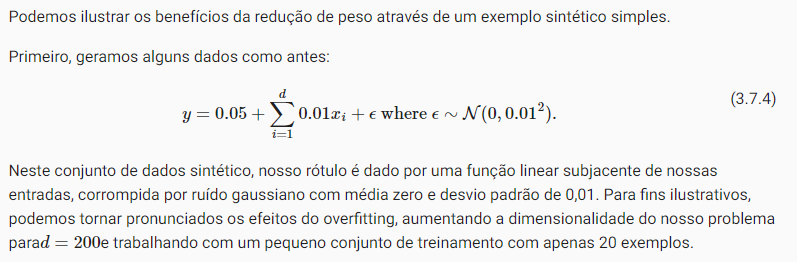

In [6]:
class Data(d2l.DataModule):
    def __init__(self, num_train, num_val, num_inputs, batch_size):
        self.save_hyperparameters()
        n = num_train + num_val
        self.X = torch.randn(n, num_inputs)
        noise = torch.randn(n, 1) * 0.01
        w, b = torch.ones((num_inputs, 1)) * 0.01, 0.05
        self.y = torch.matmul(self.X, w) + b + noise

    def get_dataloader(self, train):
        i = slice(0, self.num_train) if train else slice(self.num_train, None)
        return self.get_tensorloader([self.X, self.y], train, i)

# 3.7.3. Implementação do zero

In [7]:
# Defining l2 Norm Penalty:
def l2_penalty(w):
    return (w ** 2).sum() / 2

# 3.7.3.2. Definindo o Modelo

A mudança da _class WeightDecayScratch(d2l.LinearRegressionScratch)_ para _class LinearRegressionScratch(d2l.Module)_ é apenas a inclusão da penalidade.

Perceba que a classe _class WeightDecayScratch(d2l.LinearRegressionScratch)_ é uma classe filha da classe mãe LinearRegressionScratch(d2l.Module)_


_sintaxe:_

_classe filha(mãe):_

In [10]:
class WeightDecayScratch(d2l.LinearRegressionScratch):
    def __init__(self, num_inputs, lambd, lr, sigma=0.01):
        super().__init__(num_inputs, lr, sigma)                # chama o método __init__() da classe Base d2l.LinearRegressionScratch
        self.save_hyperparameters()

    def loss(self, y_hat, y):
        return (super().loss(y_hat, y) +                       # chama o método loss() da classe Base d2l.LinearRegressionScratch
                self.lambd * l2_penalty(self.w))

O código a seguir ajusta nosso modelo no conjunto de treinamento com 20 exemplos e o avalia no conjunto de validação com 100 exemplos.

In [11]:
data = Data(num_train=20, num_val=100, num_inputs=200, batch_size=5)
trainer = d2l.Trainer(max_epochs=10)

def train_scratch(lambd):
    model = WeightDecayScratch(num_inputs=200, lambd=lambd, lr=0.01)
    model.board.yscale='log'
    trainer.fit(model, data)
    print('L2 norm of w:', float(l2_penalty(model.w)))

# 3.7.3.3. Treinamento sem Regularização

Agora executamos este código desativando a redução de peso (lambd = 0). Assim teremos overfitting.

L2 norm of w: 0.010792642831802368


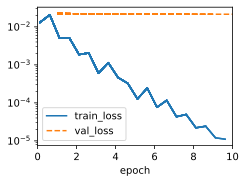

In [13]:
train_scratch(0)

Overfitting: diminiui o erro de treinamento mas não o erro de validação.

Agora com redução substancial de peso:

L2 norm of w: 0.0013922650832682848


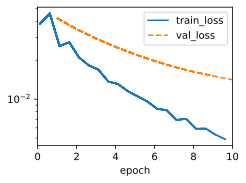

In [14]:
train_scratch(3)

# 3.7.4. Implementação concisa


In [15]:
class WeightDecay(d2l.LinearRegression):
    def __init__(self, wd, lr):             # wd é o lambd da implementação anterior.
        super().__init__(lr)
        self.save_hyperparameters()
        self.wd = wd

    def configure_optimizers(self):
        return torch.optim.SGD([
            {'params': self.net.weight, 'weight_decay': self.wd},
            {'params': self.net.bias}], lr=self.lr)

O gráfico é semelhante ao de quando implementamos a redução de peso do zero. No entanto, esta versão é executada mais rapidamente e é mais fácil de implementar, benefícios que se tornarão mais pronunciados à medida que você resolver problemas maiores e esse trabalho se tornar mais rotineiro.

L2 norm of w: 0.011762354522943497


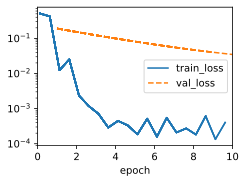

In [17]:
model = WeightDecay(wd=3, lr=0.01)          # wd é o lambd da implementação anterior.
model.board.yscale='log'
trainer.fit(model, data)

print('L2 norm of w:', float(l2_penalty(model.get_w_b()[0])))

__Neste livro, frequentemente adotaremos a heurística comum pela qual a redução de peso é aplicada a todas as camadas de uma rede profunda.__

# 3.7.5. Resumo

A regularização é um método comum para lidar com overfitting. As técnicas clássicas de regularização adicionam um termo de penalidade à função de perda (durante o treinamento) para reduzir a complexidade do modelo aprendido. Uma escolha particular para manter o modelo simples é usar um l2 norm penalização.

# Implementação do zero - agrupada

L2 norm of w: 0.0017028562724590302


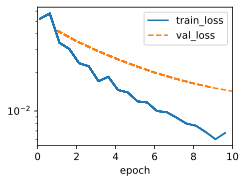

In [19]:
import torch
from torch import nn
from d2l import torch as d2l

# --------------------------------------------------------------------------------------------------------------------
class Data(d2l.DataModule):
    def __init__(self, num_train, num_val, num_inputs, batch_size):
        self.save_hyperparameters()
        n = num_train + num_val
        self.X = torch.randn(n, num_inputs)
        noise = torch.randn(n, 1) * 0.01
        w, b = torch.ones((num_inputs, 1)) * 0.01, 0.05
        self.y = torch.matmul(self.X, w) + b + noise

    def get_dataloader(self, train):
        i = slice(0, self.num_train) if train else slice(self.num_train, None)
        return self.get_tensorloader([self.X, self.y], train, i)

# --------------------------------------------------------------------------------------------------------------------
# Defining l2 Norm Penalty:
def l2_penalty(w):
    return (w ** 2).sum() / 2

# --------------------------------------------------------------------------------------------------------------------
class WeightDecayScratch(d2l.LinearRegressionScratch):
    def __init__(self, num_inputs, lambd, lr, sigma=0.01):
        super().__init__(num_inputs, lr, sigma)                # chama o método __init__() da classe Base d2l.LinearRegressionScratch
        self.save_hyperparameters()

    def loss(self, y_hat, y):
        return (super().loss(y_hat, y) +                       # chama o método loss() da classe Base d2l.LinearRegressionScratch
                self.lambd * l2_penalty(self.w))

# --------------------------------------------------------------------------------------------------------------------
data = Data(num_train=20, num_val=100, num_inputs=200, batch_size=5)
trainer = d2l.Trainer(max_epochs=10)

# --------------------------------------------------------------------------------------------------------------------
def train_scratch(lambd):
    model = WeightDecayScratch(num_inputs=200, lambd=lambd, lr=0.01)
    model.board.yscale='log'
    trainer.fit(model, data)
    print('L2 norm of w:', float(l2_penalty(model.w)))

# --------------------------------------------------------------------------------------------------------------------
train_scratch(3)

# Implementação do zero agrupada - sem plot

In [1]:
import torch
from torch import nn
from d2l import torch as d2l


v = []
t = []

# -------------------------------------------------------------------------------------
class Module(d2l.nn_Module, d2l.HyperParameters):
    """The base class of models.

    Defined in :numref:`sec_oo-design`"""
    def __init__(self, plot_train_per_epoch=2, plot_valid_per_epoch=1):
        super().__init__()
        self.save_hyperparameters()
        self.board = d2l.ProgressBoard()

    def loss(self, y_hat, y):
        raise NotImplementedError

    def forward(self, X):
        assert hasattr(self, 'net'), 'Neural network is defined'
        return self.net(X)

    def plot(self, key, value, train):
        """Plot a point in animation."""
        assert hasattr(self, 'trainer'), 'Trainer is not inited'
        # self.board.xlabel = 'epoch'
        if train:
            x = self.trainer.train_batch_idx / \
                self.trainer.num_train_batches
            n = self.trainer.num_train_batches / \
                self.plot_train_per_epoch
        else:
            x = self.trainer.epoch + 1
            n = self.trainer.num_val_batches / \
                self.plot_valid_per_epoch
        # self.board.draw(x, d2l.numpy(d2l.to(value, d2l.cpu())),
        #                 ('train_' if train else 'val_') + key,
        #                 every_n=int(n))

    def training_step(self, batch):
        l = self.loss(self(*batch[:-1]), batch[-1])
        # self.plot('loss', l, train=True)
        print(f'train_loss: {l}')
        t.append(l)
        return l


    def validation_step(self, batch):
        l = self.loss(self(*batch[:-1]), batch[-1])
        # self.plot('loss', l, train=False)
        print(f'val1_loss: {l}')
        v.append(l)


    def configure_optimizers(self):
        raise NotImplementedError

    def configure_optimizers(self):
        """Defined in :numref:`sec_classification`"""
        return torch.optim.SGD(self.parameters(), lr=self.lr)

    def apply_init(self, inputs, init=None):
        """Defined in :numref:`sec_lazy_init`"""
        self.forward(*inputs)
        if init is not None:
            self.net.apply(init)



# -----------------------------------------------------------------------------------
class LinearRegressionScratch(Module):
    """The linear regression model implemented from scratch.

    Defined in :numref:`sec_linear_scratch`"""
    def __init__(self, num_inputs, lr, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.w = d2l.normal(0, sigma, (num_inputs, 1), requires_grad=True)
        self.b = d2l.zeros(1, requires_grad=True)

    def forward(self, X):
        """Defined in :numref:`sec_linear_scratch`"""
        return d2l.matmul(X, self.w) + self.b

    def loss(self, y_hat, y):
        """Defined in :numref:`sec_linear_scratch`"""
        l = (y_hat - y) ** 2 / 2
        return d2l.reduce_mean(l)

    def configure_optimizers(self):
        """Defined in :numref:`sec_linear_scratch`"""
        return d2l.SGD([self.w, self.b], self.lr)

# --------------------------------------------------------------------------------------------------------------------
class Data(d2l.DataModule):
    def __init__(self, num_train, num_val, num_inputs, batch_size):
        self.save_hyperparameters()
        n = num_train + num_val
        self.X = torch.randn(n, num_inputs)
        noise = torch.randn(n, 1) * 0.01
        w, b = torch.ones((num_inputs, 1)) * 0.01, 0.05
        self.y = torch.matmul(self.X, w) + b + noise

    def get_dataloader(self, train):
        i = slice(0, self.num_train) if train else slice(self.num_train, None)
        return self.get_tensorloader([self.X, self.y], train, i)

# --------------------------------------------------------------------------------------------------------------------
# Defining l2 Norm Penalty:
def l2_penalty(w):
    return (w ** 2).sum() / 2

# --------------------------------------------------------------------------------------------------------------------
class WeightDecayScratch(LinearRegressionScratch):
    def __init__(self, num_inputs, lambd, lr, sigma=0.01):
        super().__init__(num_inputs, lr, sigma)                # chama o método __init__() da classe Base d2l.LinearRegressionScratch
        self.save_hyperparameters()

    def loss(self, y_hat, y):
        return (super().loss(y_hat, y) +                       # chama o método loss() da classe Base d2l.LinearRegressionScratch
                self.lambd * l2_penalty(self.w))

# --------------------------------------------------------------------------------------------------------------------
data = Data(num_train=20, num_val=100, num_inputs=200, batch_size=5)
trainer = d2l.Trainer(max_epochs=10)

# --------------------------------------------------------------------------------------------------------------------
def train_scratch(lambd):
    model = WeightDecayScratch(num_inputs=200, lambd=lambd, lr=0.01)
    model.board.yscale='log'
    trainer.fit(model, data)
    print('L2 norm of w:', float(l2_penalty(model.w)))

# --------------------------------------------------------------------------------------------------------------------
train_scratch(3)

train_loss: 0.03664366155862808
train_loss: 0.04003262519836426
train_loss: 0.04252538084983826
train_loss: 0.10321057587862015
val1_loss: 0.041056662797927856
val1_loss: 0.06497421860694885
val1_loss: 0.03577490150928497
val1_loss: 0.03926418721675873
val1_loss: 0.07050172239542007
val1_loss: 0.04938049614429474
val1_loss: 0.041841357946395874
val1_loss: 0.05257426202297211
val1_loss: 0.05412498116493225
val1_loss: 0.04256148636341095
val1_loss: 0.03052278235554695
val1_loss: 0.04166636988520622
val1_loss: 0.046455901116132736
val1_loss: 0.026733284816145897
val1_loss: 0.05615313723683357
val1_loss: 0.04623236879706383
val1_loss: 0.04882025718688965
val1_loss: 0.030998624861240387
val1_loss: 0.028887029737234116
val1_loss: 0.034537069499492645
train_loss: 0.0449204295873642
train_loss: 0.02334357425570488
train_loss: 0.021950749680399895
train_loss: 0.02882666513323784
val1_loss: 0.03437188267707825
val1_loss: 0.056612126529216766
val1_loss: 0.028391998261213303
val1_loss: 0.033031746

# Implementação concisa - agrupada

L2 norm of w: 0.014913087710738182


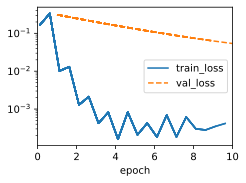

In [1]:
import torch
from torch import nn
from d2l import torch as d2l

# --------------------------------------------------------------------------------------------------------------------
class Data(d2l.DataModule):
    def __init__(self, num_train, num_val, num_inputs, batch_size):
        self.save_hyperparameters()
        n = num_train + num_val
        self.X = torch.randn(n, num_inputs)
        noise = torch.randn(n, 1) * 0.01
        w, b = torch.ones((num_inputs, 1)) * 0.01, 0.05
        self.y = torch.matmul(self.X, w) + b + noise

    def get_dataloader(self, train):
        i = slice(0, self.num_train) if train else slice(self.num_train, None)
        return self.get_tensorloader([self.X, self.y], train, i)


# --------------------------------------------------------------------------------------------------------------------

# Defining l2 Norm Penalty:
def l2_penalty(w):
    return (w ** 2).sum() / 2

# --------------------------------------------------------------------------------------------------------------------
class WeightDecay(d2l.LinearRegression):
    def __init__(self, wd, lr):             # wd é o lambd da implementação anterior.
        super().__init__(lr)
        self.save_hyperparameters()
        self.wd = wd

    def configure_optimizers(self):
        return torch.optim.SGD([
            {'params': self.net.weight, 'weight_decay': self.wd},
            {'params': self.net.bias}], lr=self.lr)

# --------------------------------------------------------------------------------------------------------------------
data = Data(num_train=20, num_val=100, num_inputs=200, batch_size=5)
trainer = d2l.Trainer(max_epochs=10)

# --------------------------------------------------------------------------------------------------------------------
model = WeightDecay(wd=3, lr=0.01)          # wd é o lambd da implementação anterior.
model.board.yscale='log'
trainer.fit(model, data)

print('L2 norm of w:', float(l2_penalty(model.get_w_b()[0])))

# Exercícios

In [ ]:
# Implementação concisa - agrupada

import torch
from torch import nn
from d2l import torch as d2l

# --------------------------------------------------------------------------------------------------------------------
class Data(d2l.DataModule):
    def __init__(self, num_train, num_val, num_inputs, batch_size):
        self.save_hyperparameters()
        n = num_train + num_val
        self.X = torch.randn(n, num_inputs)
        noise = torch.randn(n, 1) * 0.01
        w, b = torch.ones((num_inputs, 1)) * 0.01, 0.05
        self.y = torch.matmul(self.X, w) + b + noise

    def get_dataloader(self, train):
        i = slice(0, self.num_train) if train else slice(self.num_train, None)
        return self.get_tensorloader([self.X, self.y], train, i)

# --------------------------------------------------------------------------------------------------------------------
class WeightDecay(d2l.LinearRegression):
    def __init__(self, wd, lr):             # wd é o lambd da implementação anterior.
        super().__init__(lr)
        self.save_hyperparameters()
        self.wd = wd

    def configure_optimizers(self):
        return torch.optim.SGD([
            {'params': self.net.weight, 'weight_decay': self.wd},
            {'params': self.net.bias}], lr=self.lr)

L2 norm of w: 0.015203339979052544


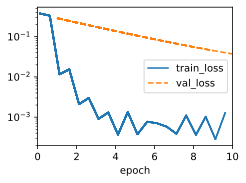

In [ ]:
# --------------------------------------------------------------------------------------------------------------------
data = Data(num_train=20, num_val=100, num_inputs=200, batch_size=5)
trainer = d2l.Trainer(max_epochs=10)

# --------------------------------------------------------------------------------------------------------------------
model = WeightDecay(wd=3, lr=0.01)          # wd é o lambd da implementação anterior.
model.board.yscale='log'
trainer.fit(model, data)

print('L2 norm of w:', float(l2_penalty(model.get_w_b()[0])))

# Ex. 1
Experiment with the value of lambd in the estimation problem in this section. Plot training and validation accuracy as a function of 
lambd. What do you observe?

L2 norm of w: 0.1519768387079239


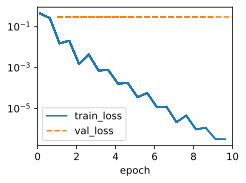

In [22]:
# --------------------------------------------------------------------------------------------------------------------
model = WeightDecay(wd=0, lr=0.01)          # wd é o lambd da implementação anterior.
model.board.yscale='log'
trainer.fit(model, data)
print('L2 norm of w:', float(l2_penalty(model.get_w_b()[0])))

L2 norm of w: 0.06568439304828644


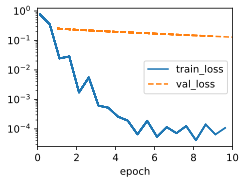

In [23]:
# --------------------------------------------------------------------------------------------------------------------
model = WeightDecay(wd=1, lr=0.01)          # wd é o lambd da implementação anterior.
model.board.yscale='log'
trainer.fit(model, data)
print('L2 norm of w:', float(l2_penalty(model.get_w_b()[0])))

L2 norm of w: 0.03373720869421959


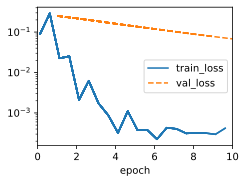

In [24]:
# --------------------------------------------------------------------------------------------------------------------
model = WeightDecay(wd=2, lr=0.01)          # wd é o lambd da implementação anterior.
model.board.yscale='log'
trainer.fit(model, data)
print('L2 norm of w:', float(l2_penalty(model.get_w_b()[0])))

L2 norm of w: 0.013595601543784142


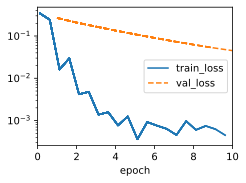

In [25]:
# --------------------------------------------------------------------------------------------------------------------
model = WeightDecay(wd=3, lr=0.01)          # wd é o lambd da implementação anterior.
model.board.yscale='log'
trainer.fit(model, data)
print('L2 norm of w:', float(l2_penalty(model.get_w_b()[0])))

L2 norm of w: 0.007389232516288757


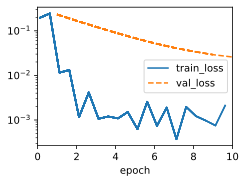

In [26]:
# --------------------------------------------------------------------------------------------------------------------
model = WeightDecay(wd=4, lr=0.01)          # wd é o lambd da implementação anterior.
model.board.yscale='log'
trainer.fit(model, data)
print('L2 norm of w:', float(l2_penalty(model.get_w_b()[0])))

L2 norm of w: 0.0036742063239216805


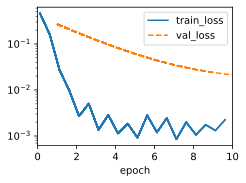

In [27]:
# --------------------------------------------------------------------------------------------------------------------
model = WeightDecay(wd=5, lr=0.01)          # wd é o lambd da implementação anterior.
model.board.yscale='log'
trainer.fit(model, data)
print('L2 norm of w:', float(l2_penalty(model.get_w_b()[0])))

L2 norm of w: 0.0009412209037691355


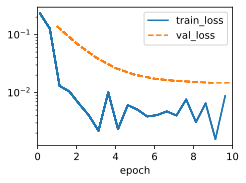

In [28]:
# --------------------------------------------------------------------------------------------------------------------
model = WeightDecay(wd=10, lr=0.01)          # wd é o lambd da implementação anterior.
model.board.yscale='log'
trainer.fit(model, data)
print('L2 norm of w:', float(l2_penalty(model.get_w_b()[0])))

L2 norm of w: 0.00020610028877854347


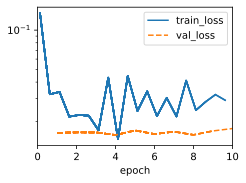

In [32]:
# --------------------------------------------------------------------------------------------------------------------
model = WeightDecay(wd=100, lr=0.01)          # wd é o lambd da implementação anterior.
model.board.yscale='log'
trainer.fit(model, data)
print('L2 norm of w:', float(l2_penalty(model.get_w_b()[0])))

L2 norm of w: 17937.8125


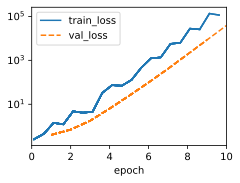

In [33]:
# --------------------------------------------------------------------------------------------------------------------
model = WeightDecay(wd=200, lr=0.01)          # wd é o lambd da implementação anterior.
model.board.yscale='log'
trainer.fit(model, data)
print('L2 norm of w:', float(l2_penalty(model.get_w_b()[0])))

L2 norm of w: 8.363834928693835e+25


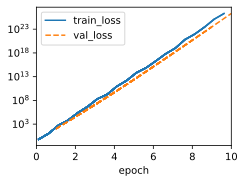

In [34]:
# --------------------------------------------------------------------------------------------------------------------
model = WeightDecay(wd=300, lr=0.01)          # wd é o lambd da implementação anterior.
model.board.yscale='log'
trainer.fit(model, data)
print('L2 norm of w:', float(l2_penalty(model.get_w_b()[0])))

Fazer plotagem x=lambda  X  y=(train loss and test loss)


# Ex. 1 - automático

Época 0 - treinamento
train_loss: 0.009169628843665123
Época 0 - treinamento
train_loss: 0.02476099506020546
Época 0 - treinamento
train_loss: 0.055573560297489166
Época 0 - treinamento
train_loss: 0.02526695467531681
Época 0 - validação
val1_loss: 0.010329650714993477
Época 0 - validação
val1_loss: 0.021602688357234
Época 0 - validação
val1_loss: 0.03570932894945145
Época 0 - validação
val1_loss: 0.0314687080681324
Época 0 - validação
val1_loss: 0.014601689763367176
Época 0 - validação
val1_loss: 0.014993679709732533
Época 0 - validação
val1_loss: 0.017773030325770378
Época 0 - validação
val1_loss: 0.03783777356147766
Época 0 - validação
val1_loss: 0.039840757846832275
Época 0 - validação
val1_loss: 0.023748721927404404
Época 0 - validação
val1_loss: 0.029184386134147644
Época 0 - validação
val1_loss: 0.01594727300107479
Época 0 - validação
val1_loss: 0.01834055781364441
Época 0 - validação
val1_loss: 0.049558110535144806
Época 0 - validação
val1_loss: 0.01079766545444727
Época 0 - va

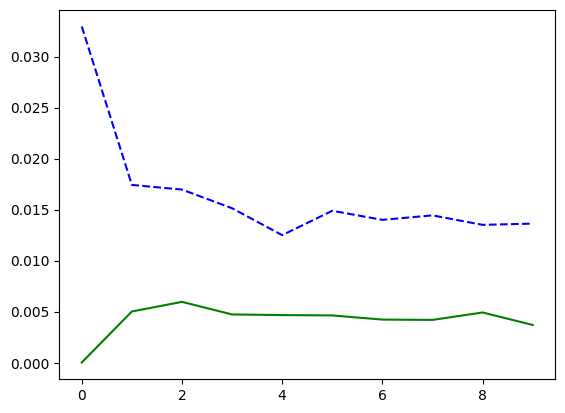

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Época 0 - treinamento
train_loss: 0.016601193696260452
Época 0 - treinamento
train_loss: 0.022527528926730156
Época 0 - treinamento
train_loss: 0.04940125718712807
Época 0 - treinamento
train_loss: 0.009331737644970417
Época 0 - validação
val1_loss: 0.003267597872763872
Época 0 - validação
val1_loss: 0.008171814493834972
Época 0 - validação
val1_loss: 0.00759471207857132
Época 0 - validação
val1_loss: 0.020594457164406776
Época 0 - validação
val1_loss: 0.03805684298276901
Época 0 - validação
val1_loss: 0.025715649127960205
Época 0 - validação
val1_loss: 0.022614259272813797
Época 0 - validação
val1_loss: 0.0186777301132679
Época 0 - validação
val1_loss: 0.0478857159614563
Época 0 - validação
val1_loss: 0.013061302714049816
Época 0 - validação
val1_loss: 0.00543725723400712
Época 0 - validação
val1_loss: 0.005532046314328909
Época 0 - validação
val1_loss: 0.022189563140273094
Época 0 - validação
val1_loss: 0.005370200611650944
Época 0 - validação
val1_loss: 0.004107556771486998
Época 0 

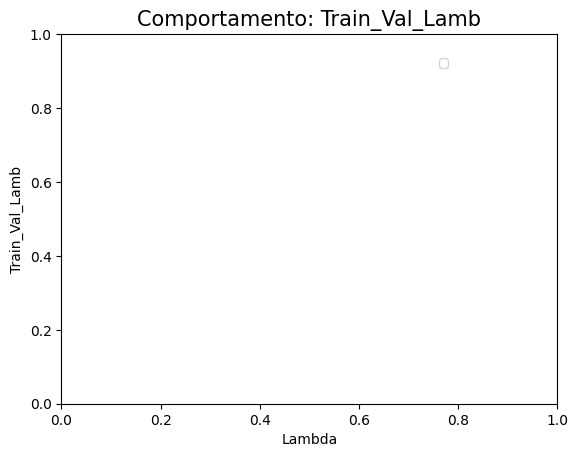

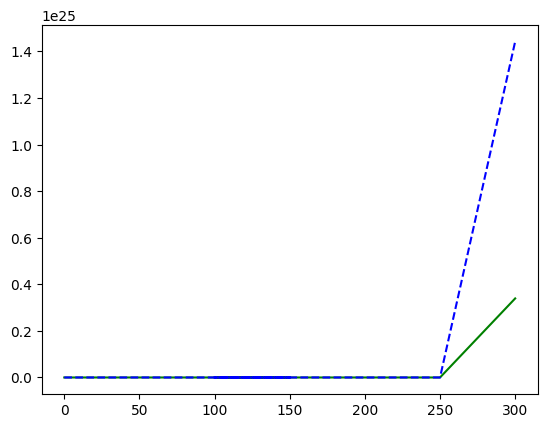

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


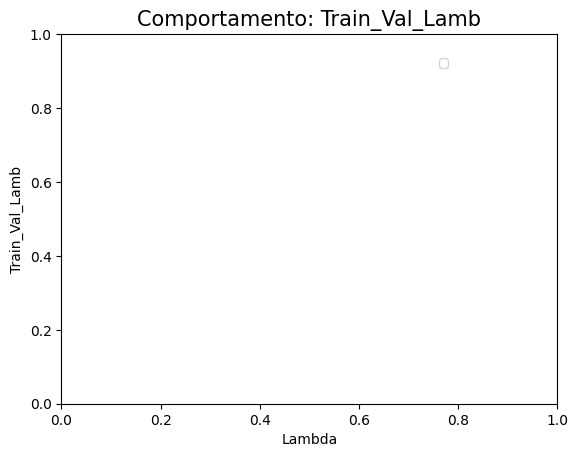

In [4]:
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l
import numpy
import matplotlib.pyplot as plt

t = []
v = []

# trainer.epoch

# v_a = np.append()

t_a = np.zeros((10,4))
v_a = np.zeros((10,20))
# -------------------------------------------------------------------------------------
class Module(d2l.nn_Module, d2l.HyperParameters):
    """The base class of models.

    Defined in :numref:`sec_oo-design`"""

    def __init__(self, plot_train_per_epoch=2, plot_valid_per_epoch=1):
        super().__init__()
        self.save_hyperparameters()
        self.board = d2l.ProgressBoard()
        self.jt = 0
        self.jv = 0

    def loss(self, y_hat, y):
        raise NotImplementedError

    def forward(self, X):
        assert hasattr(self, 'net'), 'Neural network is defined'
        return self.net(X)

    def plot(self, key, value, train):
        """Plot a point in animation."""
        assert hasattr(self, 'trainer'), 'Trainer is not inited'
        # self.board.xlabel = 'epoch'         ######COMENTAR PARA NÃO PLOTAR#######
        if train:
            x = self.trainer.train_batch_idx / \
                self.trainer.num_train_batches
            n = self.trainer.num_train_batches / \
                self.plot_train_per_epoch
        else:
            x = self.trainer.epoch + 1
            n = self.trainer.num_val_batches / \
                self.plot_valid_per_epoch
        # self.board.draw(x, d2l.numpy(d2l.to(value, d2l.cpu())),         ######COMENTAR PARA NÃO PLOTAR#######
        #                 ('train_' if train else 'val_') + key,         ######COMENTAR PARA NÃO PLOTAR#######
        #                 every_n=int(n))         ######COMENTAR PARA NÃO PLOTAR#######


    def training_step(self, batch):
        l = self.loss(self(*batch[:-1]), batch[-1])
        # self.plot('loss', l, train=True)         ######COMENTAR PARA NÃO PLOTAR#######
        i = trainer.epoch       # 10 épocas
        print(f'Época {i} - treinamento')
        print(f'train_loss: {l}')

        t.append(l)
        # print(len(t))

        # Preenchendo a matriz:
        # train_batch_idx = 40
        t_a[i][self.jt] = l

        if self.jt == 3:
            self.jt = 0
        else:
             self.jt = self.jt + 1

        return l



    def validation_step(self, batch):
        l = self.loss(self(*batch[:-1]), batch[-1])
        # self.plot('loss', l, train=False)         ######COMENTAR PARA NÃO PLOTAR#######
        i = trainer.epoch
        print(f'Época {i} - validação')
        print(f'val1_loss: {l}')
        v.append(l)

        # Preenchendo a matriz:
        # val_batch_idx = 200
        v_a[i][self.jv] = l
        if self.jv == 19:
            self.jv = 0
        else:
             self.jv = self.jv + 1

    def configure_optimizers(self):
        raise NotImplementedError

    def configure_optimizers(self):
        """Defined in :numref:`sec_classification`"""
        return torch.optim.SGD(self.parameters(), lr=self.lr)

    def apply_init(self, inputs, init=None):
        """Defined in :numref:`sec_lazy_init`"""
        self.forward(*inputs)
        if init is not None:
            self.net.apply(init)





# -----------------------------------------------------------------------------------
class LinearRegressionScratch(Module):
    """The linear regression model implemented from scratch.

    Defined in :numref:`sec_linear_scratch`"""
    def __init__(self, num_inputs, lr, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.w = d2l.normal(0, sigma, (num_inputs, 1), requires_grad=True)
        self.b = d2l.zeros(1, requires_grad=True)

    def forward(self, X):
        """Defined in :numref:`sec_linear_scratch`"""
        return d2l.matmul(X, self.w) + self.b

    def loss(self, y_hat, y):
        """Defined in :numref:`sec_linear_scratch`"""
        l = (y_hat - y) ** 2 / 2
        return d2l.reduce_mean(l)

    def configure_optimizers(self):
        """Defined in :numref:`sec_linear_scratch`"""
        return d2l.SGD([self.w, self.b], self.lr)

# --------------------------------------------------------------------------------------------------------------------
class Data(d2l.DataModule):
    def __init__(self, num_train, num_val, num_inputs, batch_size):
        self.save_hyperparameters()
        n = num_train + num_val
        self.X = torch.randn(n, num_inputs)
        noise = torch.randn(n, 1) * 0.01
        w, b = torch.ones((num_inputs, 1)) * 0.01, 0.05
        self.y = torch.matmul(self.X, w) + b + noise

    def get_dataloader(self, train):
        i = slice(0, self.num_train) if train else slice(self.num_train, None)
        return self.get_tensorloader([self.X, self.y], train, i)

# --------------------------------------------------------------------------------------------------------------------
# Defining l2 Norm Penalty:
def l2_penalty(w):
    return (w ** 2).sum() / 2

# --------------------------------------------------------------------------------------------------------------------
class WeightDecayScratch(LinearRegressionScratch):
    def __init__(self, num_inputs, lambd, lr, sigma=0.01):
        super().__init__(num_inputs, lr, sigma)                # chama o método __init__() da classe Base d2l.LinearRegressionScratch
        self.save_hyperparameters()

    def loss(self, y_hat, y):
        return (super().loss(y_hat, y) +                       # chama o método loss() da classe Base d2l.LinearRegressionScratch
                self.lambd * l2_penalty(self.w))

# --------------------------------------------------------------------------------------------------------------------
data = Data(num_train=20, num_val=100, num_inputs=200, batch_size=5)
trainer = d2l.Trainer(max_epochs=10)

# --------------------------------------------------------------------------------------------------------------------
def train_scratch(lambd):
    model = WeightDecayScratch(num_inputs=200, lambd=lambd, lr=0.01)
    model.board.yscale='log'
    trainer.fit(model, data)
    print('L2 norm of w:', float(l2_penalty(model.w)))

# --------------------------------------------------------------------------------------------------------------------


# train_scratch(3)



lamb_test = [0,1,2,3,4,5,6,7,8,9]
y1 = []
y2 = []

for la in lamb_test:
    train_scratch(la)
    y1.append(t_a[-1, -1])
    y2.append(v_a[-1, -1])


plt.plot(lamb_test,y1,'g-', label = 'train')
plt.plot(lamb_test,y2,'b--', label = 'val')
plt.show()
plt.ylabel('Train_Val_Lamb')
plt.xlabel('Lambda')
plt.title(r'Comportamento: Train_Val_Lamb', fontsize=15)
plt.legend(bbox_to_anchor=(0.75,0.95), loc='upper left',fontsize='small')




lamb_test = [0,50,150,100,150,200,250,300]
y1 = []
y2 = []

for la in lamb_test:
    train_scratch(la)
    y1.append(t_a[-1, -1])
    y2.append(v_a[-1, -1])

plt.figure(2)
plt.plot(lamb_test,y1,'g-',label = 'train')
plt.plot(lamb_test,y2,'b--',label = 'val')
plt.show()
plt.ylabel('Train_Val_Lamb')
plt.xlabel('Lambda')
plt.title(r'Comportamento: Train_Val_Lamb', fontsize=15)
plt.legend(bbox_to_anchor=(0.75,0.95), loc='upper left',fontsize='small')

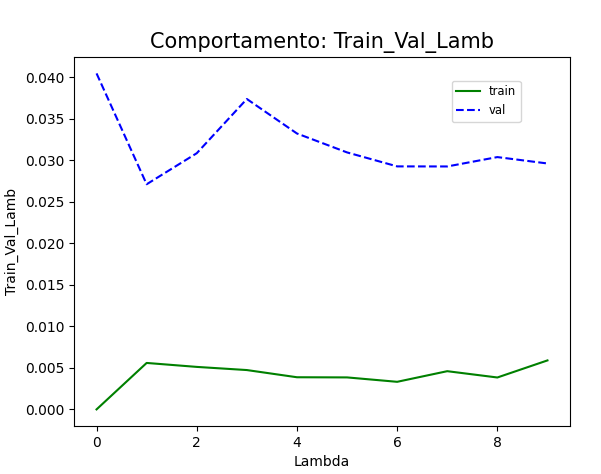

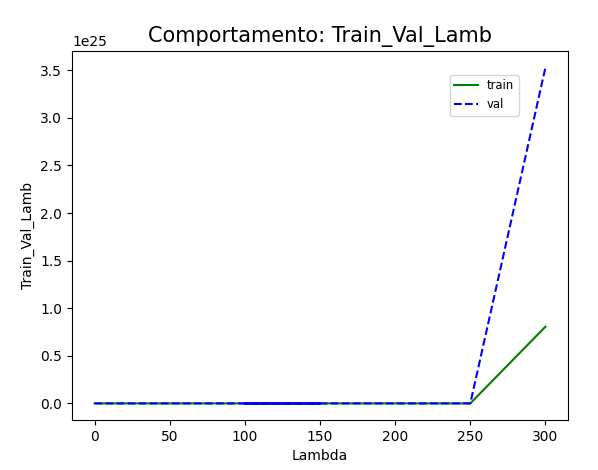

Demais exercícios, vide:

https://pandalab.me/archives/weight_decay

5. Review the relationship between training error and generalization error. In addition to weight decay, increased training, and the use of a model of suitable complexity, what other ways might help us deal with overfitting?
The relationship between training error and generalization error is a fundamental concept in machine learning. Training error is the error that a model makes on the data it was trained on, while generalization error is the error it makes on new, unseen data. The goal is to build a model that has a low generalization error, which indicates that it can perform well on data it has never encountered before.

Here’s a review of the relationship between training and generalization error, along with additional techniques to deal with overfitting:

Training Error vs. Generalization Error:

Training Error: Training error measures how well the model fits the training data. A model that perfectly fits the training data might suffer from overfitting, where it learns the noise in the data rather than the underlying patterns.

Generalization Error: Generalization error measures how well the model performs on new, unseen data. A model with high generalization error might be underfitting, meaning it fails to capture the underlying patterns in the data.

Ways to Deal with Overfitting:

Regularization Techniques: Regularization methods like weight decay (L2 regularization) and L1 regularization can prevent overfitting by adding a penalty to the loss function, encouraging the model to have smaller weights or inducing sparsity in the weights.

Cross-Validation: Cross-validation helps estimate a model’s generalization performance by splitting the data into training and validation sets. It provides a better sense of how well the model will perform on new data and helps in selecting hyperparameters.

Early Stopping: Monitor the validation error during training and stop training once the validation error starts increasing. This prevents the model from overfitting the training data as training progresses.

Data Augmentation: Increasing the size of the training dataset by applying transformations to the data (e.g., rotation, cropping, flipping) can help the model generalize better and reduce overfitting.

Feature Engineering: Selecting relevant features and reducing irrelevant ones can help the model focus on the most important patterns in the data, reducing overfitting.

Ensemble Methods: Combining the predictions of multiple models can improve generalization. Techniques like bagging, boosting, and random forests create diverse models that collectively perform better on new data.

Dropout: Dropout is a regularization technique used mainly in neural networks. It randomly deactivates a portion of the neurons during each training iteration, forcing the network to learn robust representations.

Simpler Models: Use models of suitable complexity. A model that is too complex can memorize the training data and overfit, while a model that is too simple might underfit.

Hyperparameter Tuning: Experiment with different hyperparameters and architectures to find the best combination that balances training and generalization.

Domain Knowledge: Incorporating domain-specific knowledge can guide the feature selection process and help avoid overfitting to noise.